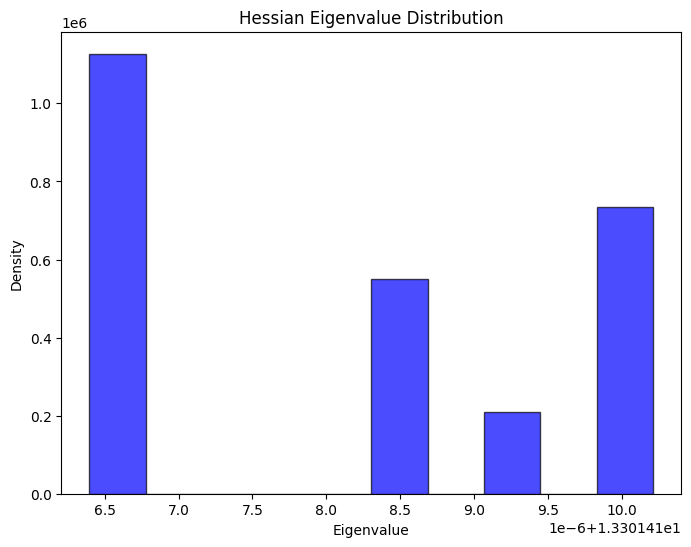

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 다층 퍼셉트론 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

# 데이터 생성
x_train = torch.randn(100, 1)
y_train = x_train ** 3 + 0.1 * torch.randn(100, 1)  # 비선형 관계 (y = x^3 + noise)

# Hessian-벡터 곱 함수 정의
def hessian_vector_product(loss, model, v):
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    flat_grad = torch.cat([g.contiguous().view(-1) for g in grad_params])
    grad_v = torch.dot(flat_grad, v)
    hv = torch.autograd.grad(grad_v, model.parameters(), retain_graph=True)
    hv = torch.cat([h.contiguous().view(-1) for h in hv]).detach()
    return hv

# 상위 k개 고유값 계산 함수
def compute_top_k_eigenvalues(model, loss, k=20, max_iter=100):
    """Hessian의 상위 k개 고유값 계산"""
    num_params = sum(p.numel() for p in model.parameters())
    device = next(model.parameters()).device
    eigenvalues = []
    eigenvectors = []
    
    for _ in range(k):
        # 랜덤 초기 벡터
        v = torch.randn(num_params).to(device)
        v = v / v.norm()
        
        for _ in range(max_iter):
            hv = hessian_vector_product(loss, model, v)
            eigenvalue = torch.dot(v, hv)
            hv_norm = hv.norm()
            if hv_norm == 0:
                break
            v = hv / hv_norm
        
        # 이미 구한 고유벡터들과 직교화
        for ev in eigenvectors:
            v = v - torch.dot(v, ev) * ev
            v = v / v.norm()
        
        eigenvalues.append(eigenvalue.item())
        eigenvectors.append(v)
    
    return eigenvalues

# 모델 초기화
model = MLPModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 모델 학습
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    predictions = model(x_train)
    loss = loss_fn(predictions, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 최종 손실 계산
final_predictions = model(x_train)
final_loss = loss_fn(final_predictions, y_train)

# Hessian 상위 고유값 계산
eigenvalues = compute_top_k_eigenvalues(model, final_loss, k=100)

# 고유값 시각화
import numpy as np

eigenvalues = np.array(eigenvalues)
plt.figure(figsize=(8, 6))
plt.hist(eigenvalues, bins=10, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title("Hessian Eigenvalue Distribution")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()


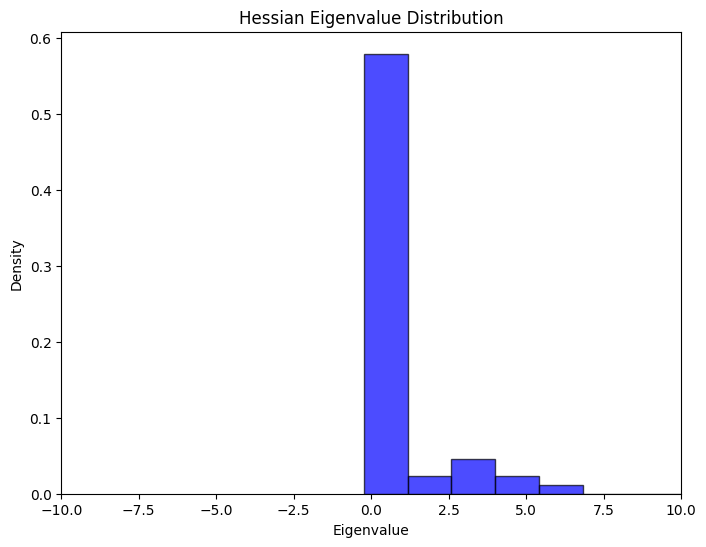

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 다층 퍼셉트론 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=20, output_dim=1):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),  # 활성화 함수를 Tanh로 변경하여 비선형성을 높입니다.
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

# 데이터 생성
x_train = torch.randn(100, 1)
y_train = x_train ** 3 + 0.1 * torch.randn(100, 1)  # 비선형 관계 (y = x^3 + noise)

# Hessian 행렬 직접 계산 함수 정의
def compute_hessian_matrix(loss, model):
    params = [p for p in model.parameters() if p.requires_grad]
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grads = torch.cat([g.contiguous().view(-1) for g in grads])
    num_params = grads.size(0)
    
    hessian = torch.zeros(num_params, num_params)
    
    for idx in range(num_params):
        grad2rd = torch.autograd.grad(grads[idx], params, retain_graph=True)
        grad2rd = torch.cat([g.contiguous().view(-1) for g in grad2rd])
        hessian[idx] = grad2rd.detach()
    
    return hessian

# 모델 초기화
model = MLPModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 모델 학습
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    predictions = model(x_train)
    loss = loss_fn(predictions, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 최종 손실 계산
final_predictions = model(x_train)
final_loss = loss_fn(final_predictions, y_train)

# Hessian 행렬 계산
hessian = compute_hessian_matrix(final_loss, model)

# 고유값 계산
eigenvalues = torch.linalg.eigvals(hessian)
eigenvalues = eigenvalues.cpu().numpy()
eigenvalues = np.real(eigenvalues)  # 실수 부분만 사용

# 고유값 시각화
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(eigenvalues, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title("Hessian Eigenvalue Distribution")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.xlim(-10, 10)  # x축을 -5에서 5로 설정하여 0을 중심으로 표시
plt.show()


Number of parameters: 31
Number of eigenvalues to compute (k): 30


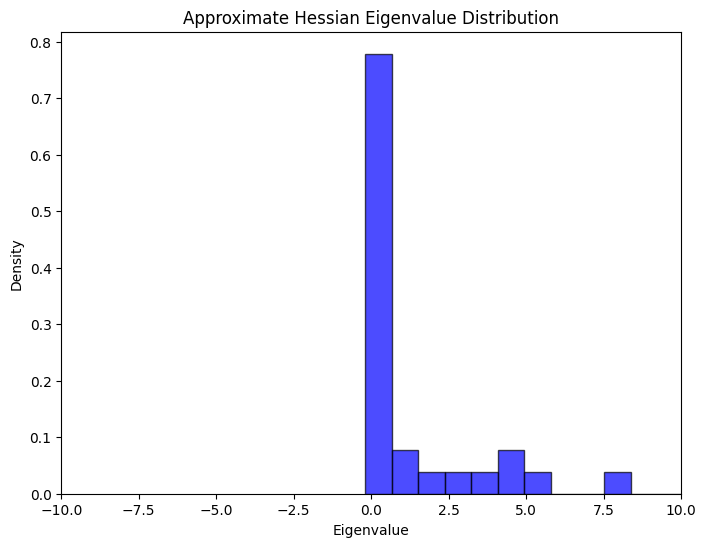

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh

# 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

# 데이터 생성
x_train = torch.randn(100, 1)
y_train = x_train ** 3 + 0.1 * torch.randn(100, 1)

# 모델 초기화 및 학습
model = MLPModel()
if torch.cuda.is_available():
    model = model.cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
    predictions = model(x_train)
    loss = loss_fn(predictions, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 최종 손실 계산
final_predictions = model(x_train)
final_loss = loss_fn(final_predictions, y_train)

# Hessian-벡터 곱 함수 정의
def hessian_vector_product(v):
    v = torch.tensor(v, dtype=torch.float32)
    if torch.cuda.is_available():
        v = v.cuda()
    grad_params = torch.autograd.grad(final_loss, model.parameters(), create_graph=True)
    flat_grad = torch.cat([g.contiguous().view(-1) for g in grad_params])
    grad_v = torch.dot(flat_grad, v)
    hv = torch.autograd.grad(grad_v, model.parameters(), retain_graph=True)
    hv = torch.cat([h.contiguous().view(-1) for h in hv]).cpu().numpy()
    return hv

# 파라미터 개수 계산
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

# k 값 설정
k = min(50, num_params - 1)  # k는 num_params보다 작아야 함
print(f"Number of eigenvalues to compute (k): {k}")

# LinearOperator 정의
HessianLinearOperator = LinearOperator((num_params, num_params), matvec=hessian_vector_product)

# 상위 및 하위 고유값 계산
eigenvalues, eigenvectors = eigsh(HessianLinearOperator, k=k, which='LM', sigma=0, return_eigenvectors=True)

# 고유값 시각화
plt.figure(figsize=(8, 6))
plt.hist(eigenvalues, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title("Approximate Hessian Eigenvalue Distribution")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.xlim(-10, 10)  # x축을 -10에서 10으로 설정하여 0을 중심으로 표시
plt.show()
